# Thermostat

Example taken from: https://arxiv.org/pdf/1410.8060

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} - \textit{temp} + 30 \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              - \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

The goal is to find the parameters $t_{on}$ and $t_{off}$ in order to maximise the probability of reaching the region $T(t) \in [19.9, 20.1]$ in mode "Heater ON (mode = -1)" at various time points $(\tau = 0.6, \tau = 1.8 \text{ and } \tau = 2.4)$.

## SOGA

In [33]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from original_models import *

['/home/rdoz/miniconda3/envs/myenv/lib/python313.zip', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/lib-dynload', '', '/home/rdoz/miniconda3/envs/myenv/lib/python3.13/site-packages', '/home/rdoz/PhD/DeGAS/src', '/tmp/tmpx9yzgiow', '/home/rdoz/PhD/DeGAS/src']


In [34]:
from optimization import *
torch.set_default_dtype(torch.float64)

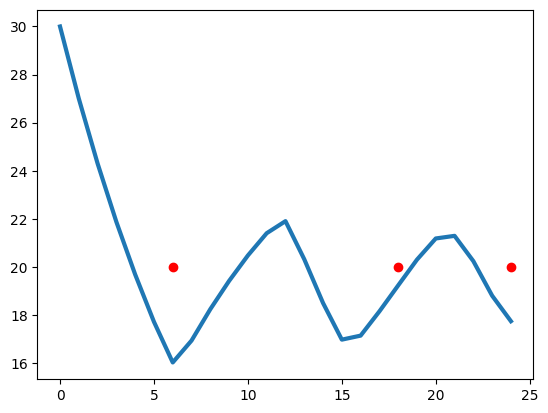

In [35]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean
orig_params = {'T': 25,   # time steps
               'init_T': 16.,  # initial temperature
               }     # turn-off temperature

soga_code = """
array[26] T;
array[26] M; 

/* Initial state */
currT = gauss(30., 1.);   
isOn = 1;                 

dt = 0.1;            

for i in range(25) {

    /* Save current state */
    T[i] = currT;
    M[i] = isOn;

    /* Continuous dynamics */
    if isOn > 0 {
        /* Cooling: dT/dt = -T */
        temp = currT * dt;
        newT = currT - temp + gauss(0., 0.1);
    } else {
        /* Heating: dT/dt = -(T-30) */
        temp = currT * dt;
        newT = currT - temp ;
        temp = 30. * dt;
        newT = newT + temp + gauss(0., 0.1);
    } end if;

    currT = newT;

    /* Mode switching */
    if isOn > 0 {
        if currT < _tOff {
            isOn = -1;
        } else {
            skip;
        } end if;
    } else {
        if currT >= _tOn {
            isOn = 1;
        } else {
            skip;
        } end if;
    } end if;

} end for;

/* Save final state */
T[25] = currT;
M[25] = isOn;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_T = orig_params['init_T']
params = {'tOff':  16.5, 'tOn':22.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
# Points to which the lines should be drawn
points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point
#plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [36]:
y = []
y_var = []
for i in range(25):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat2_init.csv', index=False)

In [37]:
print(output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), idx = int(np.round(0.6/0.1))+25))

tensor([[274.6873]], grad_fn=<MmBackward0>)


In [38]:
dt = 0.1
time_index_1 = int(np.round(0.6/dt))
print(time_index_1)
time_index_2 = int(np.round(1.8/dt))
print(time_index_2)
time_index_3 = int(np.round(2.4/dt))
print(time_index_3)


6
18
24


In [39]:
output_dist.gm.marg_pdf(torch.tensor([-1., -1., -1.]).unsqueeze(0), idx = [1, 2, 3]).squeeze()

tensor(0., grad_fn=<SqueezeBackward0>)

In [40]:
T_idx = [i for i in range(output_dist.gm.n_dim()) if 'T[' in output_dist.var_list[i]]
M_idx = [i for i in range(output_dist.gm.n_dim()) if 'M[' in output_dist.var_list[i]]

#loss = lambda dist : -((dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(0.6/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(0.6/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(0.6/dt))+25).squeeze()
                       #*(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(1.8/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(1.8/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(1.8/dt))+25).squeeze()
                       #*(dist.gm.marg_cdf(torch.tensor([20.1]), idx=int(np.round(2.4/dt))) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=int(np.round(2.4/dt))))*dist.gm.marg_pdf(torch.tensor(-1.).unsqueeze(-1), idx = int(np.round(2.4/dt))+25).squeeze())
#print(loss(output_dist))

loss = lambda dist : -((dist.gm.marg_cdf(torch.tensor([20.1]), idx=[int(np.round(0.6/dt)), int(np.round(1.8/dt)), int(np.round(2.4/dt))]) - dist.gm.marg_cdf(torch.tensor([19.9]), idx=[int(np.round(0.6/dt)), int(np.round(1.8/dt)), int(np.round(2.4/dt))]))*dist.gm.marg_pdf(torch.tensor([-1., -1., -1.]).unsqueeze(0), idx = [int(np.round(0.6/dt))+25, int(np.round(1.8/dt))+25, int(np.round(2.4/dt))+25]).squeeze())
print(loss(output_dist))

tensor([[-6.3915e-07]], grad_fn=<NegBackward0>)


tOff: 16.500999272644773 tOn: 21.99900204194512  loss: -6.391472646355698e-07
tOff: 16.50199932800669 tOn: 21.998003353253424  loss: -6.625797104808721e-07
tOff: 16.503000675123236 tOn: 21.997003473086092  loss: -6.86819995688104e-07
tOff: 16.504003818134876 tOn: 21.99600194584127  loss: -7.118460295565505e-07
tOff: 16.505009258471674 tOn: 21.994998317928793  loss: -7.379216104013278e-07
tOff: 16.506017491689175 tOn: 21.99399214149284  loss: -7.649893571940713e-07
tOff: 16.50702900584955 tOn: 21.992982976151126  loss: -7.93031125590674e-07
tOff: 16.50804428469496 tOn: 21.991970384594683  loss: -8.223651710560488e-07
tOff: 16.50906380155995 tOn: 21.9909539400952  loss: -8.5272552102891e-07
tOff: 16.510088019003433 tOn: 21.989933226712694  loss: -8.841364911747437e-07
tOff: 16.511117394225874 tOn: 21.9889078321191  loss: -9.170568518142635e-07
tOff: 16.512152377494708 tOn: 21.9878773493679  loss: -9.515683125206042e-07
tOff: 16.513193397945216 tOn: 21.98684134367176  loss: -9.86252067144

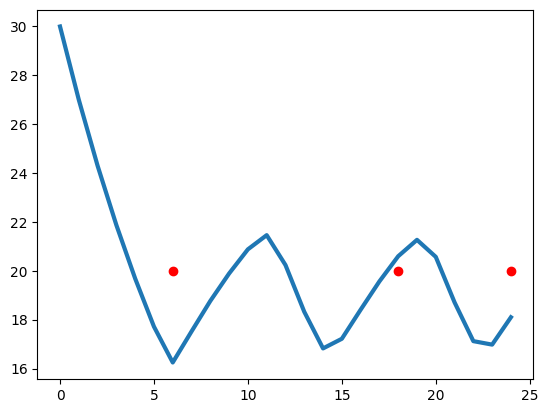

In [41]:
# Optimization in SOGA
# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(params)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=200, lr=0.001)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_opt = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_opt, lw=3, label='SOGA w true params')

points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point

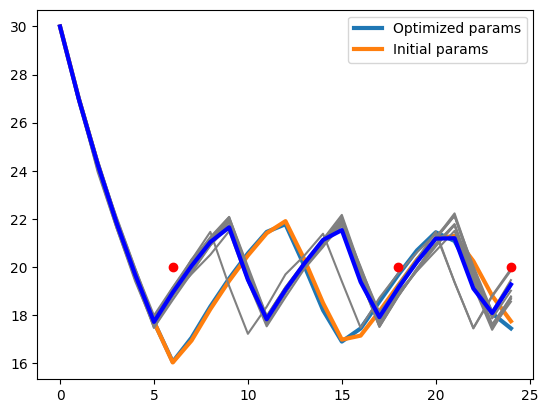

In [24]:
orig_params, n_traj, params, var_name, model, n_steps, lr = get_orig_params('thermostat')
orig_params['tOff'] = 21.30
orig_params['tOn'] = 19.04
orig_params['init_T'] = 30
orig_params['T'] = 25
orig_params['k'] = 0.1
orig_params['h'] = 3.
orig_traj, mode = generate_traj(model, n_traj, orig_params)
plt.plot(range(T), y_opt, lw=3, label='Optimized params')
plt.plot(range(T), y_init, lw=3, label='Initial params')
#plot all the trajectories
plot_traj_set(orig_traj, single_traj=10)
plt.legend()
points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
for point in points:
    plt.plot(point[0], point[1], 'ro')  # Red dot at each point

In [30]:
idx=[int(np.round(0.6/dt)), int(np.round(1.8/dt)), int(np.round(2.4/dt))]
count_success = 0
for traj in orig_traj:
    for i in idx:
        if mode[i] == True and traj[i] >= 19.9 and traj[i] <= 20.1:
            count_success += 1

print(f"Number of successful trajectories: {count_success} out of {len(orig_traj)}")    

Number of successful trajectories: 9 out of 100


In [28]:
idx

[6, 18, 24]

In [11]:
y = []
y_var = []
for i in range(25):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('T['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('T['+ str(i) +']'), output_dist.var_list.index('T['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('thermostat2_opt.csv', index=False)

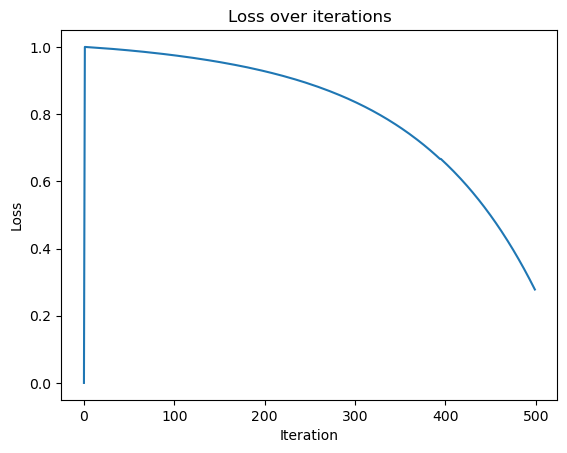

In [12]:
# export loss_list to csv
#normalize loss_list
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('thermostat2_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()